# Notebook 04 - Parameter Sweep / Sensitivity Analysis

本 Notebook 用于对 momentum 与 swing 检测的关键参数进行敏感性分析（调参）。

我们关注三个核心超参数：
- Momentum EWMA span：控制势头曲线平滑程度
- Swing amp_q：幅度阈值分位数（越大越严格）
- Swing cool：相邻 swing 事件的最小间隔（越大越稀疏）

输出：
1) 参数组合的统计表（swing_count、amp_thr 等），保存到 reports/tables/
2) 少量代表性可视化图（用于论文/报告），保存到 reports/figures/


In [2]:
import sys
from pathlib import Path

PROJECT_ROOT = Path.cwd().parent
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

import numpy as np
import pandas as pd
from src.data.match import (
    load_raw_points_csv,
    get_match,
    add_point_result,
    add_serve_adjusted_contrib,
)

from src.features.momentum import compute_momentum
from src.features.swings import detect_swings, SwingParams
from src.viz.plots import plot_momentum_with_swings



In [3]:
# =========================
# 参数面板（只改这一格）
# =========================

MATCH_ID = "2023-wimbledon-1701"

DATA_PATH = "../data/raw/Wimbledon_featured_matches.csv"
FIG_DIR = Path("../reports/figures")
TAB_DIR = Path("../reports/tables")

# momentum sweep
SPAN_LIST = [15, 25, 40]     # EWMA span 候选

# swing sweep
TREND_SPAN = 5               # 先固定（需要也可 sweep）
AMP_Q_LIST = [0.80, 0.85, 0.90, 0.95]
COOL_LIST = [0, 10, 15, 25]  # 0 表示不加冷却

# 是否保存少量代表图（建议 True）
SAVE_SAMPLE_FIGS = True

# 代表图选取规则：从 sweep 里挑几个组合展示
SAMPLE_CONFIGS = [
    {"span": 15, "amp_q": 0.80, "cool": 10},
    {"span": 25, "amp_q": 0.85, "cool": 15},
    {"span": 40, "amp_q": 0.90, "cool": 25},
]


## 数据准备

- 读取全量逐分数据
- 抽取单场比赛并排序
- 构造 point_result（±1）
- 构造 serve-adjusted 单分贡献 serve_adj_p1（并得到 p_server）


In [4]:
df = load_raw_points_csv(DATA_PATH)
df_match = get_match(df, MATCH_ID)
df_match = add_point_result(df_match)
df_match, p_server = add_serve_adjusted_contrib(df_match)

print("match:", MATCH_ID)
print("rows:", df_match.shape[0])
print("p_server:", round(p_server, 4))
df_match.head(3)


match: 2023-wimbledon-1701
rows: 334
p_server: 0.6108


,match_id,player1,player2,elapsed_time,set_no,game_no,point_no,p1_sets,p2_sets,p1_games,...,p2_distance_run,rally_count,speed_mph,serve_width,serve_depth,return_depth,point_result,serve_wins,serve_adj,serve_adj_p1
0,2023-wimbledon-1701,Carlos Alcaraz,Novak Djokovic,00:00:00,1,1,1,0,0,0,...,4.341,1,111.0,W,CTL,D,-1,1,0.389222,-0.389222
1,2023-wimbledon-1701,Carlos Alcaraz,Novak Djokovic,00:00:25,1,1,2,0,0,0,...,22.307,4,126.0,BW,NCTL,ND,1,0,-0.610778,0.610778
2,2023-wimbledon-1701,Carlos Alcaraz,Novak Djokovic,00:01:19,1,1,3,0,0,0,...,2.926,2,102.0,BW,NCTL,ND,1,0,-0.610778,0.610778


## 参数扫网格（Grid Sweep）

对每组 (span, amp_q, cool)：
- 先计算 momentum（srv_ewm）
- 再检测 swing
- 记录：
  - swing_count：swing 点数量
  - amp_thr：该配置下的实际阈值
  - mean_abs_m：势头幅度均值（辅助参考）
  - max_abs_m：势头幅度最大值（辅助参考）


In [5]:
results = []

for span in SPAN_LIST:
    m = compute_momentum(df_match, method="srv_ewm", span=span)

    mean_abs_m = float(m.abs().mean())
    max_abs_m = float(m.abs().max())

    for amp_q in AMP_Q_LIST:
        for cool in COOL_LIST:
            params = SwingParams(
                trend_span=TREND_SPAN,
                amp_q=amp_q,
                cool=cool
            )

            swing_flag, swing_pos, amp_thr = detect_swings(m, params=params)

            results.append({
                "match_id": MATCH_ID,
                "p_server": p_server,
                "span": span,
                "trend_span": TREND_SPAN,
                "amp_q": amp_q,
                "cool": cool,
                "amp_thr": float(amp_thr),
                "swing_count": int(swing_flag.sum()),
                "mean_abs_m": mean_abs_m,
                "max_abs_m": max_abs_m,
            })

df_res = pd.DataFrame(results)
df_res.sort_values(["span", "amp_q", "cool"]).head()


,match_id,p_server,span,trend_span,amp_q,cool,amp_thr,swing_count,mean_abs_m,max_abs_m
0,2023-wimbledon-1701,0.610778,15,5,0.80,0,0.175119,13,0.107021,0.389222
1,2023-wimbledon-1701,0.610778,15,5,0.80,10,0.175119,9,0.107021,0.389222
2,2023-wimbledon-1701,0.610778,15,5,0.80,15,0.175119,6,0.107021,0.389222
3,2023-wimbledon-1701,0.610778,15,5,0.80,25,0.175119,6,0.107021,0.389222
4,2023-wimbledon-1701,0.610778,15,5,0.85,0,0.188901,7,0.107021,0.389222


## 结果概览（Pivot Table）

我们先用 pivot table 看：
- span 变大 → 一般更平滑 → swing_count 往往减少
- amp_q 变大 → 更严格 → swing_count 减少
- cool 变大 → 更稀疏 → swing_count 减少


In [6]:
# 固定 cool=15，先看 span x amp_q 的 swing_count
pivot = df_res[df_res["cool"] == 15].pivot_table(
    index="span", columns="amp_q", values="swing_count", aggfunc="mean"
)

pivot


amp_q,0.80,0.85,0.90,0.95
span,,,,
15,6.0,3.0,2.0,1.0
25,4.0,3.0,3.0,2.0
40,4.0,4.0,3.0,1.0


## 保存统计表到 reports/tables

保存：
- 全量网格结果：便于后续写论文或画更多对比
- pivot 结果：便于报告展示


In [7]:
TAB_DIR.mkdir(parents=True, exist_ok=True)

csv_all = TAB_DIR / f"{MATCH_ID}_param_sweep_all.csv"
df_res.to_csv(csv_all, index=False)

csv_pivot = TAB_DIR / f"{MATCH_ID}_param_sweep_pivot_cool15.csv"
pivot.to_csv(csv_pivot)

csv_all, csv_pivot


(WindowsPath('../reports/tables/2023-wimbledon-1701_param_sweep_all.csv'),
 WindowsPath('../reports/tables/2023-wimbledon-1701_param_sweep_pivot_cool15.csv'))

## 生成少量代表配置图（用于论文展示）

我们不建议把所有组合都画图（太多、太乱）。  
只挑 2-4 个代表组合，体现“参数如何影响 swing 检测”即可。


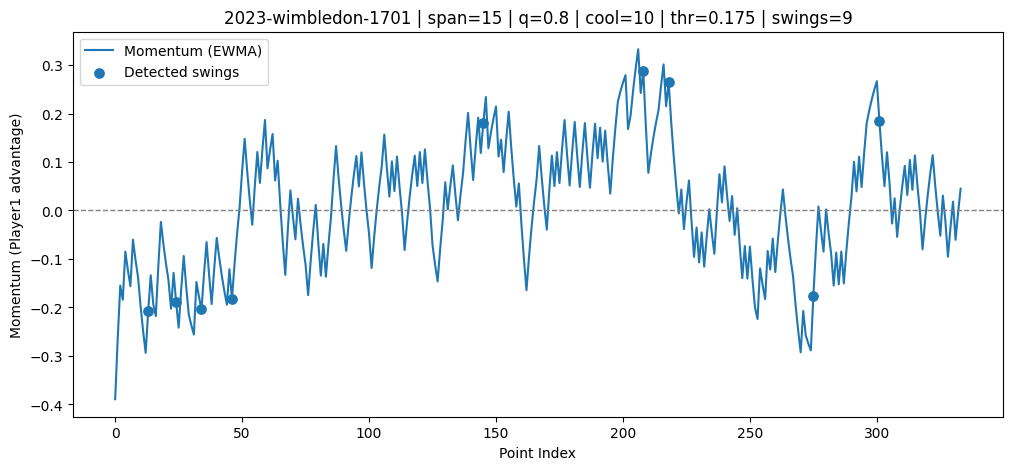

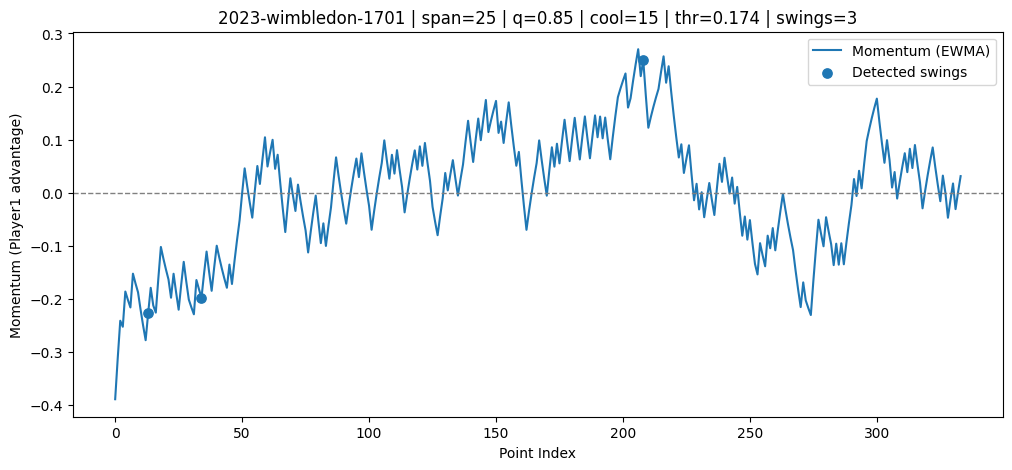

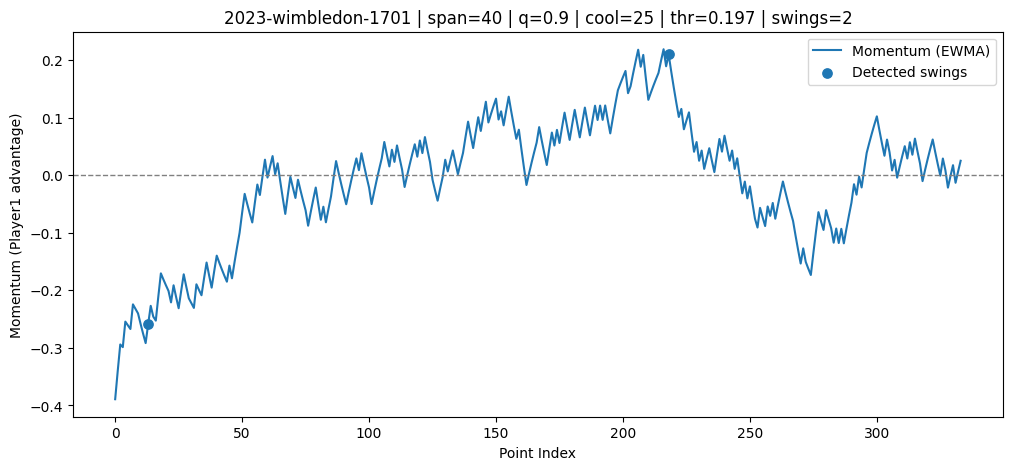

In [8]:
if SAVE_SAMPLE_FIGS:
    FIG_DIR.mkdir(parents=True, exist_ok=True)

    for cfg in SAMPLE_CONFIGS:
        span = cfg["span"]
        amp_q = cfg["amp_q"]
        cool = cfg["cool"]

        m = compute_momentum(df_match, method="srv_ewm", span=span)
        params = SwingParams(trend_span=TREND_SPAN, amp_q=amp_q, cool=cool)
        swing_flag, swing_pos, amp_thr = detect_swings(m, params=params)

        out_path = FIG_DIR / f"{MATCH_ID}_span{span}_q{amp_q}_cool{cool}.png"
        title = f"{MATCH_ID} | span={span} | q={amp_q} | cool={cool} | thr={amp_thr:.3f} | swings={int(swing_flag.sum())}"

        plot_momentum_with_swings(
            m,
            swing_flag=swing_flag,
            title=title,
            out_path=out_path
        )


## 论文/报告可用的敏感性分析结论

- 当 EWMA span 增大时，势头曲线更平滑，检测到的 swing 事件数量通常减少，说明模型对短期扰动更不敏感。
- 当幅度阈值分位数 amp_q 增大时，只保留更强的势头反转，swing 数量显著减少，体现了对“重大转折”的筛选作用。
- 当冷却时间 cool 增大时，相邻 swing 被合并/稀疏化，结果更接近人工标注的“关键转折点”。


